##### Machine Learning LAB 1: MODEL SELECTION

Course 2025/26: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **MODEL SELECTION AND VALIDATION**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Polynomial Classification on Signal to Noise Ratios

In this notebook we are going to explore the use of polynomial classification with polynomial regression. We are going to use the Numpy **polyfit** function, which performs polynomial regression.

Our use case is a communication problem: we have a set of measurements of the Signal to Noise Ratio (SNR), i.e., the quality of the communication link, in various positions. The SNR depends on two components: firstly, the noise level (which is a random variable that does not depend on position) and the signal attenuation (usually modeled as a polynomial function of the distance).

Our transmitter is in (0,0), and coordinates are in meters. In urban scenarios, the attenuation usually follows a third-degree polynomial, but it might be a fourth- or fifth-degree polynomial in more complex cases. How do we choose between different degrees? We will try with a maximum of **6**

---

## Import all the necessary Python libraries

In [273]:
# ---> warning: in this notebook, numpy is used as little as possible.
# As an exercise one could try to implement everything without Numpy, but this would mean having to change list handling inside function definitions.
# It would instead be more interesting to implement np.polyfit by hand, ie with linear algebra.
# Minor cleanups also needed here.
import numpy as np
#import scipy as sp
import pandas as pd
import itertools
from matplotlib import pyplot as plt
import random

---

## Load the data

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [274]:
df = pd.read_csv('data/snr_measurements.csv',sep=';')
x = df['x'].to_numpy()
y = df['y'].to_numpy()
#print(type(x))
SNR = df['SNR'].to_numpy()

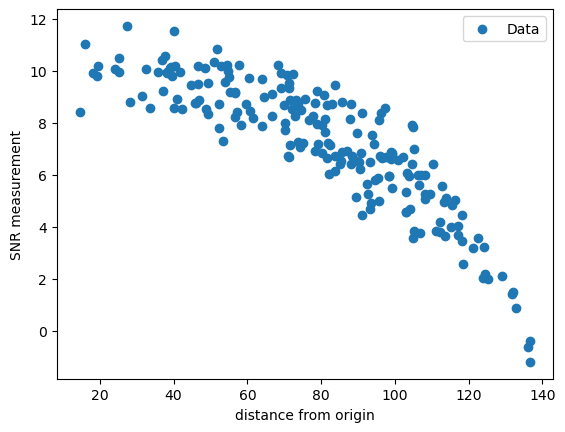

In [275]:
#plt.scatter(x,y)
d_data=np.sqrt(x**2 + y**2) # ---> distance data
plt.scatter(x=d_data, y=SNR, label='Data')
plt.xlabel('distance from origin')
plt.ylabel('SNR measurement')
plt.legend()
plt.show()

## Helper functions

These functions will help us evaluate the results

In [276]:
#a = [1,2,3,7,8,9,10]
#b= [111,112,113,117,118,119,1110]
#for i in range(len(a)):
#    print(i)

In [277]:
def compute_distance(x1, x2):
    # Euclidean distance from the origin of a vector of components x1, x2
    # check that floats?
    distance = np.sqrt(x1**2 + x2**2)
    return distance
   
#print(compute_distance(0,-0.01))

def fit(distance, SNR, degree):
    return np.polyfit(x=distance, y=SNR, deg=degree) # least squares polynomial fit, SNR as funct of distance from origin of (x,y) 
    # returns coefficients highest to lowest in a np array

def predict(distance, poly_coeffs):
    # Predict the SNR from a given model 
    # (of single distance-point for given coeffs)
    acc=0
    size = np.size(poly_coeffs)
    degree = size -1
    for i in range(size):
        acc += poly_coeffs[degree-i] * distance**i
    SNR = acc
    return SNR
    
#a=np.array([1,1,4]) # deg 2, size 3 -> i = 0,1,2
#print(a[1])
#print(predict(1,a))

def evaluate(distance, SNR, poly_coeffs): # ---> NB distance and SNR here are arrays of the same lenght
    # Compute the error of the polynomial fit on the chosen data
    mse = 0
    for i in range(len(distance)):
        predicted_SNR=predict(distance[i], poly_coeffs)
        mse += (SNR[i]-predicted_SNR)**2
    return mse/len(distance)
    
#ev = evaluate(
#print(ev)

def separate_test(distance, SNR, test_points):
    # Return a training set and a test set (the test_points parameter controls the number of test points).
    # The points should be selected randomly 
    indexes = list(range(len(distance))) # ---> NB range return type is different from list
    test_index = random.sample(population = indexes, k = test_points) # ---> returns list
    train_index = [i for i in indexes if i not in test_index]
    x_test = distance[test_index]
    # ---> NB works fine even tho they're both lists, no need for "for i in indexes: x_test.append(distance[i])"
    # NB bc must select the CORRESPONDING x and y 's
    y_test = SNR[test_index] 
    x_train = distance[train_index]
    y_train = SNR[train_index]
    
    return x_train, y_train, x_test, y_test # ---> returns tuple

#separate_test(a, 

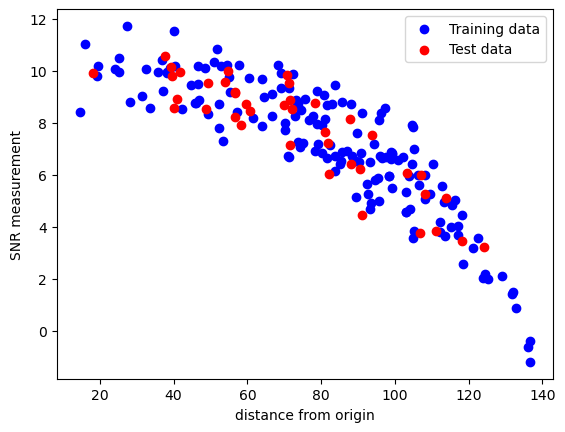

In [278]:
# create a scatter plot of the SNR as a function of the distance
#plt.scatter(x,y)

#N = int(0.2 * len(d)) # ---> returns integer part of number (ie floor)
d= compute_distance(x,y) 
N_test_points=40
distance_separated = separate_test(distance = d, SNR = SNR, test_points = N_test_points)

plt.scatter(x=distance_separated[0], y=distance_separated[1], label='Training data', color = 'b')
plt.scatter(x=distance_separated[2], y=distance_separated[3], label='Test data', color= 'r')
plt.xlabel('distance from origin')
plt.ylabel('SNR measurement')
plt.legend()
plt.show()

## A. K-fold cross-validation

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

In [279]:
#list(range(8))

In [280]:
# Function to perform the K-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, max_degree: int, k: int) -> tuple[tuple, tuple]:
    # TODO: Perform K-fold cross-validation on the training set.
    # The two returned values are the best model and the list of results for all degrees up to max_degree.
    # The points should be selected randomly.
    # The inputs and labels are already in terms of distance and SNR

    results = [[],[]]
    mse_perf= 1e9
    # split in max_degree+1 folds:
   
    for n in range(max_degree+1):
        original_indexes = list(range(len(x_train))) 
        new_indexes = original_indexes
        N_in_fold = len(original_indexes) // k
    
        # create a list of max_degree+1 lists of indexes, ie split the original list of indexes randomly
        indexes_list = []
        for i in range(k):
            indexes = random.sample(population = new_indexes, k=N_in_fold) 
            indexes_list.append(indexes)
            new_indexes = [x for x in original_indexes if x not in indexes]
        #print(indexes_list)
        mse_list=[]
        # create model for each degree:
        for i in range(k):
            validation_indexes = indexes_list[i]
            #print(validation_indexes)
            training_indexes = []
            for fold in indexes_list: # eg 1st,2nd,3rd,4th lists
                    if fold != validation_indexes:
                        training_indexes.extend(fold)
            #print(training_indexes)
            validation_set_x = x_train[validation_indexes]
            #print(validation_set_x)
            validation_set_y = y_train[validation_indexes]
            training_set_x = x_train[training_indexes]
            training_set_y = y_train[training_indexes]
            #print(validation_set_y)
            coefficients = fit(training_set_x, training_set_y, n)
            #print(coefficients)
            predicted_y = predict(validation_set_x, coefficients) # ---> predicted y on validation set
           # print(predicted_y)
            mse = evaluate(validation_set_x, validation_set_y, coefficients)
            mse_list.append(mse)
            #print(mse)
        # averaged_mse = np.average(mse_list) 
        averaged_mse = 0
        for i in mse_list:
            averaged_mse += i
        averaged_mse /= k
        results[0].append(coefficients)
        results[1].append(averaged_mse)
        if averaged_mse < mse_perf:    
            best = fit(x_train, y_train, max_degree) # ---> NB retrain on the whole set 
    return best, results

# ---> technically should also test on the 

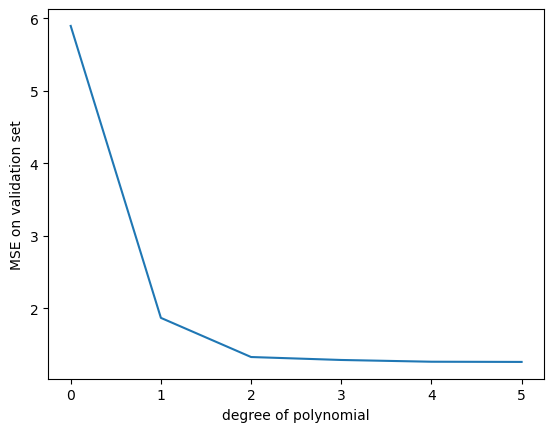

In [281]:
# run the training with K-fold cross-validation with 40 test points and 4 folds Plot the validation score as a function of the degree
md = 5
n_folds = 4
kfold_res = k_fold_cross_validation(x_train = d, y_train = SNR, max_degree= md, k = n_folds)

deglist= list(range(md+1))
#print(deglist)
#print(res[0], '\n', res[1])
plt.plot(deglist, res[1][1])
plt.xlabel('degree of polynomial')
plt.ylabel('MSE on validation set')
plt.show()

In [282]:
# get the test performance of the best model and plot the model output and test points. 
# Try running the program multiple times, changing the values of K and the number of test points: is the output always the same?

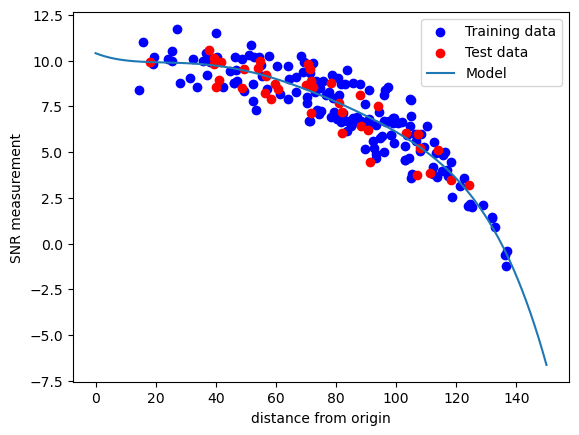

In [283]:
x_values = np.linspace(0,150,num=1000)
predicted_kfold_best = predict(x_values, kfold_res[0])
#evaluated_best = evaluate(distance_separated[2], distance_separated[3], res[0])
#print(evaluated_best)
#print(distance_separated[2], '\n', predicted_best)
plt.scatter(x=distance_separated[0], y=distance_separated[1], label='Training data', color = 'b')
plt.scatter(x=distance_separated[2], y=distance_separated[3], label='Test data', color= 'r')
plt.plot(x_values, predicted_kfold_best, label='Model')
plt.xlabel('distance from origin')
plt.ylabel('SNR measurement')
plt.legend()

---

## B. Tikhonov regularization

Change the loss function to include a Tikhonov regularization term, as an alternative to cross-validation (try $\lambda=0.01$)

In [284]:
def squared_norm(array): # python or np 1d array, varying return type
    acc=0
    for x in array: acc+=x*x
    return acc

def average_of_components(array):
    acc = 0
    for i in range(len(array)):
        acc += array[i]
    acc /= len(array)
    return acc

#average_of_components(np.array([4,2,1]))
#squared_norm(np.array([1,3,4]))

In [285]:
def evaluate_tikhonov(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # apply Tikhonov regularization AFTER the fitting process
    # ---> NB no averages needed!
    results = [[],[]]
    loss_perf= 1e9
    # create model for each degree:
    for n in range(max_degree+1):
        coefficients = fit(x_train, y_train, n)
        mse = evaluate(x_train, y_train, coefficients) 
        loss = mse + lambda_par * squared_norm(coefficients)
        results[0].append(coefficients)
        results[1].append(loss)
    if loss < loss_perf:
        best = coefficients   
    return best, results

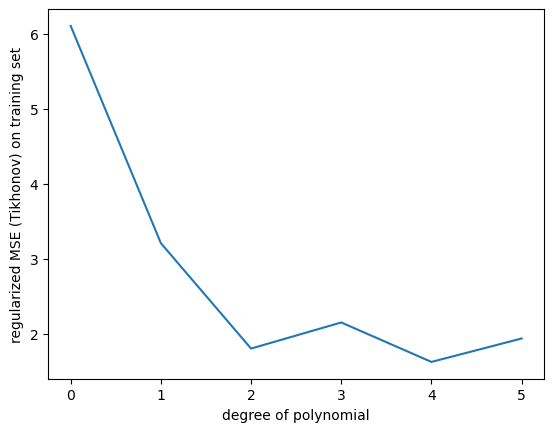

In [286]:
# run the training with Tikhonov regularization and plot the loss as a function of the degree
#md = 5
#n_test_points = 40
lbd_tik = 0.01
#distance = compute_distance(x, y)

#x_train, y_train, x_test, y_test = separate_test(distance, SNR, n_test_points)
tik_res = evaluate_tikhonov(x_train = x_train, y_train = y_train, max_degree= md, lambda_par = lbd_tik)
#print(res[1][1])

#deglist= list(range(md+1))
plt.plot(deglist, tik_res[1][1])
plt.xlabel('degree of polynomial')
plt.ylabel('regularized MSE (Tikhonov) on training set')
plt.show()

## C. Minimum description length regularization

Change the loss function to include a representation length regularization term, as an alternative to cross-validation. The minimum description length of a polynomial of degree N is O(2^N) - try $\lambda=0.02$

In [288]:
def evaluate_representation(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # apply MDL regularization AFTER the fitting process
    results = [[],[]]
    loss_perf= 1e9
    # create model for each degree:
    for n in range(max_degree+1):
        coefficients = fit(x_train, y_train, n)
        mse = evaluate(x_train, y_train, coefficients) 
        loss = mse + lambda_par * 2**max_degree
        results[0].append(coefficients)
        results[1].append(loss)
    if loss < loss_perf:
        best = coefficients   
    return best, results

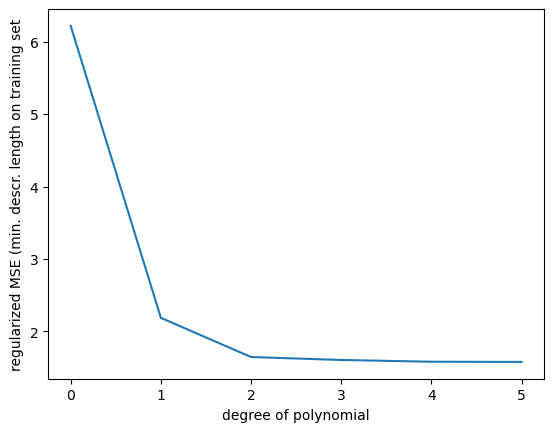

In [289]:
# run the training with MDL regularization and plot the loss as a function of the degree
#md = 5
#n_test_points = 40
lbd_mdl = 0.02
#distance = compute_distance(x, y)

#x_train, y_train, x_test, y_test = separate_test(distance, SNR, n_test_points)
mdl_res = evaluate_representation(x_train = x_train, y_train = y_train, max_degree= md, lambda_par = lbd_mdl)

#deglist= list(range(md+1))
plt.plot(deglist, mdl_res[1][1])
plt.xlabel('degree of polynomial')
plt.ylabel('regularized MSE (min. descr. length on training set')
plt.show()

### TEST

Check the performance of the three solutions on the test set: which one does best?


Each MSE is: 0.7595762082007467 for k-fold cross validation, 0.7919606918067151 for Tikhonov regularisation, and 0.7919606918067151 for Minimum description length regularisation


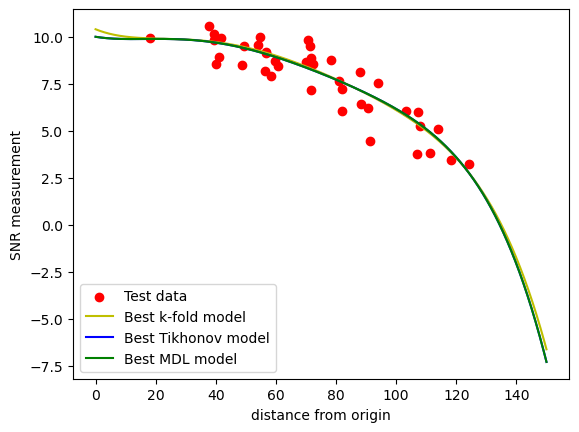

In [290]:
kfold_mse = evaluate(x_test, y_test, kfold_res[0])
tik_mse = evaluate(x_test, y_test, tik_res[0])
mdl_mse = evaluate(x_test, y_test, mdl_res[0])
print(f"Each MSE is: {kfold_mse} for k-fold cross validation, {tik_mse} for Tikhonov regularisation, and {mdl_mse} for Minimum description length regularisation")

predicted_kfold_best = predict(x_values, kfold_res[0])
predicted_tik_best = predict(x_values, tik_res[0])
predicted_mdl_best = predict(x_values, mdl_res[0])
plt.scatter(x=distance_separated[2], y=distance_separated[3], label='Test data', color= 'r')
predicted_tik_best = predict(x_values, tik_res[0])
predicted_mdl_best = predict(x_values, mdl_res[0])
plt.plot(x_values, predicted_kfold_best, label='Best k-fold model', color = 'y')
plt.plot(x_values, predicted_tik_best, label='Best Tikhonov model', color = 'b')
plt.plot(x_values, predicted_mdl_best, label='Best MDL model', color = 'g')
plt.xlabel('distance from origin')
plt.ylabel('SNR measurement')
plt.legend(loc='best')